# Summary:
This notebook will cover loading json files to metadata, data cleaning and exploratory data analysis.

# Table of contents
* [1. Load metadata](#Part1_link)
* [2. Load json_files to compile metadata](#Part2_link)
* [3. Merge metadata and json_files](#Part3_link)
* [4. Cleaning metadata](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 Remove duplicates](#Part4.1_link)
<br >&nbsp;&nbsp;&nbsp;[4.2 Articles with pubmed_id](#Part4.2_link)
<br >&nbsp;&nbsp;&nbsp;[4.3 Remove papers with no text in title and abstract](#Part4.3_link)
<br >&nbsp;&nbsp;&nbsp;[4.4 Remove papers not published in English](#Part4.4_link)
* [5. Exploratory data analysis](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 Check journals](#Part5.1_link)
<br >&nbsp;&nbsp;&nbsp;[5.2 publish_time](#Part5.2_link)
<br >&nbsp;&nbsp;&nbsp;[5.3 wordcount](#Part5.3_link)

In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import json
import glob
from ast import literal_eval

import gensim
import nltk
from nltk.stem import WordNetLemmatizer

from langdetect import detect
from tqdm import tqdm

In [2]:
base_dir="/Volumes/Yuchen_Drive/COVID19/CORD19"

<a id='Part1_link'></a>
## 1. Load metadata

In [3]:
meta_df1=pd.read_csv(os.path.join(base_dir,"CORD-19-research-challenge/metadata.csv"),
                    dtype={"pubmed_id":str,"Microsoft Academic Paper ID":str,"doi":str},parse_dates=["publish_time"])
print(meta_df1.shape)
meta_df1.head()

(47298, 18)


/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4


In [4]:
print(meta_df1.sha.nunique())

34275


In [5]:
meta_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47298 entries, 0 to 47297
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   cord_uid                     47298 non-null  object        
 1   sha                          34283 non-null  object        
 2   source_x                     47298 non-null  object        
 3   title                        47140 non-null  object        
 4   doi                          43956 non-null  object        
 5   pmcid                        28038 non-null  object        
 6   pubmed_id                    35409 non-null  object        
 7   license                      47298 non-null  object        
 8   abstract                     39048 non-null  object        
 9   publish_time                 47289 non-null  datetime64[ns]
 10  authors                      45189 non-null  object        
 11  journal                      42894 non-nu

In [6]:
meta_df1.isnull().sum()

cord_uid                           0
sha                            13015
source_x                           0
title                            158
doi                             3342
pmcid                          19260
pubmed_id                      11889
license                            0
abstract                        8250
publish_time                       9
authors                         2109
journal                         4404
Microsoft Academic Paper ID    46334
WHO #Covidence                 45530
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8829
url                              302
dtype: int64

In [7]:
meta_df1.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url'],
      dtype='object')

<a id='Part2_link'></a>
## 2. Load json_files to compile metadata

In [8]:
json_files=glob.glob(os.path.join(base_dir,"CORD-19-research-challenge/**/*.json"),recursive=True)
print("Total number of json files: {}".format(len(json_files)))

Total number of json files: 52097


In [9]:
class FileReader:
    def __init__(self,file_path):
        with open(file_path) as file:
            content=json.load(file)
            self.paper_id=content["paper_id"]
            self.title=content["metadata"]["title"]
            self.abstract=[]
            self.body_text=[]
            self.authors=[]
            self.affiliation=[]
            self.ref=[]
            self.ref_authors=[]
            
            ## title
            if not self.title:
                self.title=np.nan
            
            ## abstract
            if "abstract" in content:
                for i in content["abstract"]:
                    self.abstract.append(i["text"])
                self.abstract=" ".join(self.abstract)
                if not self.abstract:
                    self.abstract=np.nan
            else:
                self.abstract=np.nan
                
            ## body_text
            if "body_text" in content:
                for i in content["body_text"]:
                    self.body_text.append(i["text"])
                self.body_text=" ".join(self.body_text)
                if not self.body_text:
                    self.body_text=np.nan
            else:
                self.body_text=np.nan
            
            ## author & affiliation
            if "metadata" in content:
                if "authors" in content["metadata"]:
                    for author in content["metadata"]["authors"]:
                        if "middle" in author:
                            middle_name=" ".join(author["middle"])
                            if middle_name:
                                author_name=" ".join([author["first"],middle_name,author["last"]])
                                self.authors.append(author_name)
                            else:
                                author_name=" ".join([author["first"],author["last"]])
                                self.authors.append(author_name)
                        if "affiliation" in author:
                            if author["affiliation"]:
                                self.affiliation.append({author_name:author["affiliation"]})
            else:
                self.authors=np.nan
                self.affiliation=np.nan
            
            ## reference & ref_authors
            if "bib_entries" in content:
                if len(content["bib_entries"])>0:
                    for bib in content["bib_entries"].values():
                        if "title" in bib:
                            self.ref.append(bib["title"])
                        if "authors" in bib:
                            for author in bib["authors"]:
                                if "middle" in author:
                                    middle_name=" ".join(author["middle"])
                                    if middle_name:
                                        author_name=" ".join([author["first"],middle_name,author["last"]])
                                        self.ref_authors.append(author_name)
                                    else:
                                        author_name=" ".join([author["first"],author["last"]])
                                        self.ref_authors.append(author_name)
            else:
                self.ref=np.nan
                self.ref_authors=np.nan

In [295]:
title_dict={}
abstract_dict={}
body_text_dict={}
authors_dict={}
affiliation_dict={}
ref_dict={}
ref_authors_dict={}

In [296]:
for file_path in json_files:
    file=FileReader(file_path)
    title_dict[file.paper_id]=file.title
    abstract_dict[file.paper_id]=file.abstract
    body_text_dict[file.paper_id]=file.body_text
    authors_dict[file.paper_id]=file.authors
    affiliation_dict[file.paper_id]=file.affiliation
    ref_dict[file.paper_id]=file.ref
    ref_authors_dict[file.paper_id]=file.ref_authors

In [298]:
df1=pd.DataFrame.from_dict(title_dict,orient="index",columns=["title2"])
df2=pd.DataFrame.from_dict(abstract_dict,orient="index",columns=["abstract2"])
df3=pd.DataFrame.from_dict(body_text_dict,orient="index",columns=["body_text"])
df4=pd.DataFrame({"authors2":list(authors_dict.values())},index=authors_dict.keys())
df5=pd.DataFrame({"affiliation":list(affiliation_dict.values())},index=affiliation_dict.keys())
df6=pd.DataFrame({"ref":list(ref_dict.values())},index=ref_dict.keys())
df7=pd.DataFrame({"ref_authors":list(ref_authors_dict.values())},index=ref_authors_dict.keys())

In [299]:
meta_df2=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=1,sort=False)

In [300]:
print(meta_df2.shape)

(52097, 7)


In [301]:
print(len(np.intersect1d(meta_df1.sha.astype(str),meta_df2.index.astype(str))))

32417


In [302]:
meta_df2["authors2_count"]=meta_df2.authors2.map(len)
meta_df2["affiliation_count"]=meta_df2.affiliation.map(len)
meta_df2["ref_count"]=meta_df2.ref.map(len)
meta_df2["ref_authors_count"]=meta_df2.ref_authors.map(len)

In [303]:
meta_df2.isnull().sum()

title2                3910
abstract2            25143
body_text             1343
authors2                 0
affiliation              0
ref                      0
ref_authors              0
authors2_count           0
affiliation_count        0
ref_count                0
ref_authors_count        0
dtype: int64

In [304]:
meta_df2["paper_id"]=meta_df2.index

In [305]:
meta_df2.head()

,title2,abstract2,body_text,authors2,affiliation,ref,ref_authors,authors2_count,affiliation_count,ref_count,ref_authors_count,paper_id
0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","[Joseph C Ward, Lidia Lasecka-Dykes, Chris Nei...",[],[Genetic economy in 598 picornaviruses: Foot-a...,"[T Jackson, T J Tuthill, D J Rowlands, N J Sto...",17,0,14,30,0015023cc06b5362d332b3baf348d11567ca2fbb
00340eea543336d54adda18236424de6a5e91c9d,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...","[Carla Mavian, Simone Marini, Costanza Manes, ...","[{'Carla Mavian': {'laboratory': '', 'institut...","[Situation Report -43, Emergence of a novel hu...","[L L M Poon, M Peiris, J Hadfield, X Tang, O A...",6,6,20,50,00340eea543336d54adda18236424de6a5e91c9d
004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across China...,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † ,...","[{'Hanchu Zhou': {'laboratory': '', 'instituti...",[World Health Organizations. Novel Coronavirus...,"[C Wang, P W Horby, F G Hayden, G F Gao]",8,7,2,4,004f0f8bb66cf446678dc13cf2701feec4f36d76
00911cf4f99a3d5ae5e5b787675646a743574496,CHEER: hierarCHical taxonomic classification f...,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...","[Jiayu Shang, Yanni Sun]","[{'Jiayu Shang': {'laboratory': '', 'instituti...",[Application of metagenomics in the human gut ...,"[W L Wang, S Y Xu, Z G Ren, L Tao, J W Jiang, ...",2,2,34,110,00911cf4f99a3d5ae5e5b787675646a743574496
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","[Salman L Butt, Eric C Erwood, Jian Zhang, Hol...","[{'Salman L Butt': {'laboratory': '', 'institu...",[Emergence of novel strains of avian infectiou...,"[S H Abro, Y A Bochkov, S L Butt, S A Callison...",7,7,46,41,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b


<a id='Part3_link'></a>
## 3. Merge metadata and json_files

In [306]:
meta_df=meta_df2.merge(meta_df1,how="left",left_on="paper_id",right_on="sha")

In [307]:
meta_df.index=meta_df["paper_id"]

In [308]:
print(meta_df.shape)
meta_df.head()

(52105, 30)


,title2,abstract2,body_text,authors2,affiliation,ref,ref_authors,authors2_count,affiliation_count,ref_count,...,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
paper_id,,,,,,,,,,,,,,,,,,,,,
0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","[Joseph C Ward, Lidia Lasecka-Dykes, Chris Nei...",[],[Genetic economy in 598 picornaviruses: Foot-a...,"[T Jackson, T J Tuthill, D J Rowlands, N J Sto...",17,0,14,...,AbstractThe positive stranded RNA genomes of p...,2020-01-11,Joseph C. Ward; Lidia Lasecka-Dykes; Chris Nei...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.01.10.901801
00340eea543336d54adda18236424de6a5e91c9d,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...","[Carla Mavian, Simone Marini, Costanza Manes, ...","[{'Carla Mavian': {'laboratory': '', 'institut...","[Situation Report -43, Emergence of a novel hu...","[L L M Poon, M Peiris, J Hadfield, X Tang, O A...",6,6,20,...,"During the past three months, a new coronaviru...",2020-03-20,Carla Mavian; Simone Marini; Costanza Manes; I...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.03.16.20034470
004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across China...,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † ,...","[{'Hanchu Zhou': {'laboratory': '', 'instituti...",[World Health Organizations. Novel Coronavirus...,"[C Wang, P W Horby, F G Hayden, G F Gao]",8,7,2,...,We integrate the human movement and healthcare...,2020-02-12,Hanchu Zhou; Jianan Yang; Kaichen Tang; Qingpe...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.02.11.20022111
00911cf4f99a3d5ae5e5b787675646a743574496,CHEER: hierarCHical taxonomic classification f...,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...","[Jiayu Shang, Yanni Sun]","[{'Jiayu Shang': {'laboratory': '', 'instituti...",[Application of metagenomics in the human gut ...,"[W L Wang, S Y Xu, Z G Ren, L Tao, J W Jiang, ...",2,2,34,...,ABSTRARCTThe fast accumulation of viral metage...,2020-03-27,Jiayu Shang; Yanni Sun,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.03.26.009001
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","[Salman L Butt, Eric C Erwood, Jian Zhang, Hol...","[{'Salman L Butt': {'laboratory': '', 'institu...",[Emergence of novel strains of avian infectiou...,"[S H Abro, Y A Bochkov, S L Butt, S A Callison...",7,7,46,...,AbstractInfectious bronchitis (IB) causes sign...,2019-05-10,Salman L. Butt; Eric C. Erwood; Jian Zhang; Ho...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/634600


In [313]:
meta_df.isnull().sum()

title2                          3915
abstract2                      25151
body_text                       1343
authors2                           0
affiliation                        0
ref                                0
ref_authors                        0
authors2_count                     0
affiliation_count                  0
ref_count                          0
ref_authors_count                  0
paper_id                           0
cord_uid                       19680
sha                            19680
source_x                       19680
title                          19716
doi                            19994
pmcid                          34446
pubmed_id                      27451
license                        19680
abstract                       23720
publish_time                   19680
authors                        20251
journal                        21094
Microsoft Academic Paper ID    51803
WHO #Covidence                 51663
has_pdf_parse                  19680
h

In [314]:
meta_df.to_csv(os.path.join(base_dir,"COVD19_meta_raw_df.csv"),index=False)

In [315]:
meta_df.loc[:,["title2","title"]].head()

,title2,title
paper_id,,
0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,The RNA pseudoknots in foot-and-mouth disease ...
00340eea543336d54adda18236424de6a5e91c9d,Analysis Title: Regaining perspective on SARS-...,Regaining perspective on SARS-CoV-2 molecular ...
004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,Healthcare-resource-adjusted vulnerabilities t...
00911cf4f99a3d5ae5e5b787675646a743574496,CHEER: hierarCHical taxonomic classification f...,CHEER: hierarCHical taxonomic classification f...
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...","Real-time, MinION-based, amplicon sequencing f..."


In [316]:
meta_df.loc[:,["abstract2","abstract"]].head()

,abstract2,abstract
paper_id,,
0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,AbstractThe positive stranded RNA genomes of p...
00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","During the past three months, a new coronaviru..."
004f0f8bb66cf446678dc13cf2701feec4f36d76,NaN,We integrate the human movement and healthcare...
00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,ABSTRARCTThe fast accumulation of viral metage...
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,AbstractInfectious bronchitis (IB) causes sign...


### Converge abstract and title columns from the two metadata datasets

In [327]:
meta_df2=meta_df.copy()

In [328]:
meta_df2["abstract2"]=meta_df2.apply(lambda x:x.abstract2 if type(x.abstract2)==str else (x.abstract if type(x.abstract)==str else np.nan),axis=1)
meta_df2["title2"]=meta_df2.apply(lambda x:x.title2 if type(x.title2)==str else (x.title2 if type(x.title2)==str else np.nan),axis=1)


In [329]:
meta_df2.head()

,title2,abstract2,body_text,authors2,affiliation,ref,ref_authors,authors2_count,affiliation_count,ref_count,...,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,title_count,text_count
paper_id,,,,,,,,,,,,,,,,,,,,,
0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","[Joseph C Ward, Lidia Lasecka-Dykes, Chris Nei...",[],[Genetic economy in 598 picornaviruses: Foot-a...,"[T Jackson, T J Tuthill, D J Rowlands, N J Sto...",17,0,14,...,Joseph C. Ward; Lidia Lasecka-Dykes; Chris Nei...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.01.10.901801,22,1728
00340eea543336d54adda18236424de6a5e91c9d,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...","[Carla Mavian, Simone Marini, Costanza Manes, ...","[{'Carla Mavian': {'laboratory': '', 'institut...","[Situation Report -43, Emergence of a novel hu...","[L L M Poon, M Peiris, J Hadfield, X Tang, O A...",6,6,20,...,Carla Mavian; Simone Marini; Costanza Manes; I...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.03.16.20034470,11,2549
004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, † ,...","[{'Hanchu Zhou': {'laboratory': '', 'instituti...",[World Health Organizations. Novel Coronavirus...,"[C Wang, P W Horby, F G Hayden, G F Gao]",8,7,2,...,Hanchu Zhou; Jianan Yang; Kaichen Tang; Qingpe...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.02.11.20022111,8,755
00911cf4f99a3d5ae5e5b787675646a743574496,CHEER: hierarCHical taxonomic classification f...,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...","[Jiayu Shang, Yanni Sun]","[{'Jiayu Shang': {'laboratory': '', 'instituti...",[Application of metagenomics in the human gut ...,"[W L Wang, S Y Xu, Z G Ren, L Tao, J W Jiang, ...",2,2,34,...,Jiayu Shang; Yanni Sun,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/2020.03.26.009001,11,5188
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","[Salman L Butt, Eric C Erwood, Jian Zhang, Hol...","[{'Salman L Butt': {'laboratory': '', 'institu...",[Emergence of novel strains of avian infectiou...,"[S H Abro, Y A Bochkov, S L Butt, S A Callison...",7,7,46,...,Salman L. Butt; Eric C. Erwood; Jian Zhang; Ho...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/634600,15,4003


In [330]:
meta_df2.isnull().sum()

title2                          3915
abstract2                      20261
body_text                       1343
authors2                           0
affiliation                        0
ref                                0
ref_authors                        0
authors2_count                     0
affiliation_count                  0
ref_count                          0
ref_authors_count                  0
paper_id                           0
cord_uid                       19680
sha                            19680
source_x                       19680
title                          19716
doi                            19994
pmcid                          34446
pubmed_id                      27451
license                        19680
abstract                       23720
publish_time                   19680
authors                        20251
journal                        21094
Microsoft Academic Paper ID    51803
WHO #Covidence                 51663
has_pdf_parse                  19680
h

In [331]:
meta_df2=meta_df2.loc[:,["title2","abstract2","body_text","authors2","pmcid","pubmed_id","publish_time","journal","ref",
                        "affiliation","ref_authors","authors2_count","affiliation_count","ref_count","ref_authors_count",
                        "paper_id","cord_uid","url"]]

In [334]:
## rename columns of the metadata
meta_df2.columns=["title","abstract","body_text","authors","pmcid","pubmed_id","publish_time","journal","ref",
                  "affiliation","ref_authors","authors_count","affiliation_count","ref_count","ref_authors_count",
                  "paper_id","cord_uid","url"]

In [337]:
meta_df2.to_csv(os.path.join(base_dir,"COVD19_meta_df.csv"),index=False)

<a id='Part4_link'></a>
## 4. Cleaning metadata

In [3]:
meta_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_df.csv"),index_col="paper_id",
                    dtype={"pmcid":str,"pubmed_id":str,"doi":str},
                    converters={"authors":literal_eval,"ref":literal_eval,"affiliation":literal_eval,"ref_authors":literal_eval},
                    parse_dates=["publish_time"])


In [310]:
meta_df["abstract_wordcount_raw"]=meta_df.abstract.map(lambda x:len(x.split()) if type(x)==str else 0)
meta_df["title_wordcount_raw"]=meta_df.title.map(lambda x:len(x.split()) if type(x)==str else 0)
meta_df["text_wordcount_raw"]=meta_df.body_text.map(lambda x:len(x.split()) if type(x)==str else 0)

In [4]:
meta_df.shape

(52105, 19)

<a id='Part4.1_link'></a>
### 4.1 Remove duplicates

In [15]:
sum(meta_df.loc[:,["title","abstract","body_text"]].duplicated())

418

In [18]:
## Mark all duplicates as True
meta_df[meta_df.loc[:,["title","abstract","body_text"]].duplicated(keep=False)]

,title,abstract,body_text,authors,pmcid,pubmed_id,publish_time,journal,ref,affiliation,ref_authors,authors_count,affiliation_count,ref_count,ref_authors_count,cord_uid,url,title_wordcount_raw,text_wordcount_raw,abstract_wordcount_raw
paper_id,,,,,,,,,,,,,,,,,,,,
30c67218bbd1a5ffe68dab7fe7dfc5bc662e05a2,Efficacy of hydroxychloroquine in patients wit...,Aims: Studies have indicated that chloroquine ...,Coronaviruses are enveloped positive-sense sin...,"[Zhaowei Chen, Jijia Hu, Zongwei Zhang, Shan J...",NaN,NaN,2020-03-23,NaN,[A Novel Coronavirus from Patients with Pneumo...,"[{'Zhaowei Chen': {'laboratory': '', 'institut...","[N Zhu, D Zhang, W Wang, A E Gorbalenya, S C B...",9,8,10,32,vh9wreex,https://doi.org/10.1101/2020.03.21.20040303,13,1242,13
4fbdf2f988d53903777041e904ad11fcd05e71c6,Efficacy of hydroxychloroquine in patients wit...,Aims: Studies have indicated that chloroquine ...,Coronaviruses are enveloped positive-sense sin...,"[Zhaowei Chen, Jijia Hu, Zongwei Zhang, Shan J...",NaN,NaN,2020-03-30,NaN,[A Novel Coronavirus from Patients with Pneumo...,"[{'Zhaowei Chen': {'laboratory': '', 'institut...","[N Zhu, D Zhang, W Wang, A E Gorbalenya, S C B...",9,8,10,32,q8l3ra55,https://doi.org/10.1101/2020.03.22.20040758,13,1242,13
02652961663ca435c195fb0ed3e43642e04cfab3,Authors' response: Plenty of coronaviruses but...,NaN,To the editor: The emergence of a novel pathog...,"[Chantal B Reusken¹, Bart Haagmans², Adam Meij...",NaN,NaN,NaT,NaN,[Epidemiological research priorities for publi...,[],"[B J Cowling, G M Leung, Cbem Reusken, E K Bro...",8,0,11,23,NaN,NaN,8,638,0
075c0ee81918f2e0158b9e1807c0a588f3e3949c,NaN,Cystoisosporosis is a leading diarrheal diseas...,Calcium-dependent protein kinases (CDPKs) are ...,"[Aruna Shrestha, Kayode K Ojo, Florian Koston,...",NaN,NaN,NaT,NaN,[Calcium-dependent signaling and kinases in ap...,"[{'Aruna Shrestha': {'laboratory': '', 'instit...","[O Billker, S Lourido, L D Sibley, V B Carruth...",17,17,44,431,NaN,NaN,0,5877,294
09e25e413faba97b87efc701d1ab8d2a18386efb,Rapid communication Effectiveness of airport s...,NaN,We evaluated effectiveness of thermal passenge...,"[Billy J Quilty, Sam Clifford, Stefan Flasche,...",NaN,NaN,NaT,NaN,[Novel Coronavirus (2019-nCoV) Situation Repor...,[{'Billy J Quilty': {'laboratory': 'Centre for...,"[ Imperial College London, Reuters, A J Kucha...",4,4,18,49,NaN,NaN,14,1870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fbde4edcdecc3d89443cf6792b7ce1ae8288b6e2,Disseminated Conidiobolus incongruus in a dog:...,Conidiobolomycosis is a rare fungal disease of...,Fungal infections due to Conidiobolus spp. are...,"[Paige E Mackey, Katharine G Cappe, Rinosh Man...",NaN,NaN,NaT,NaN,[A higher-level phylogenetic classification of...,"[{'Paige E Mackey': {'laboratory': '', 'instit...","[D S Hibbert, A M Grooters, C P Stephens, J A ...",10,7,19,80,NaN,NaN,12,2176,74
fd606942b39e160390d5d5f09962ed7727387da3,Case report: Detection of the Middle East resp...,The Middle East respiratory syndrome coronavir...,The Middle East respiratory syndrome coronavir...,[Waleed H Mahallawi],NaN,NaN,NaT,NaN,"[Where Are We Now?, Middle East respiratory sy...","[{'Waleed H Mahallawi': {'laboratory': '', 'in...","[C Thomas, Mers-Cov, R S Almaghrabi, A S Omra...",1,1,18,80,NaN,NaN,19,1385,111
ff06cba5cad7222bc52ec82eb74279350f7cc32e,Haemophilus parainfluenzae endocarditis with m...,NaN,"Haemophilus parainfluenzae, one of the HACEK o...","[Alicia De Castro, Mohammad Abu-Hishmeh, Ibrah...",NaN,NaN,NaT,NaN,"[on behalf of the AEPEI Study Group, et al. Pr...","[{'Alicia De Castro': {'laboratory': '', 'inst...","[C Selton-Suty, M Celard, Le Moing, V Doco-Lec...",4,4,16,87,NaN,NaN,13,1597,0


In [20]:
print(meta_df.shape)
meta_df.drop_duplicates(["title","abstract","body_text"],inplace=True)
print(meta_df.shape)

(52105, 20)
(51687, 20)


<a id='Part4.2_link'></a>
### 4.2 Articles with pubmed_id

In [33]:
sum(meta_df.pubmed_id.isnull())

27041

In [7]:
meta_df["abstract_wordcount_raw"]=meta_df.abstract.apply(lambda x:len(x.split()) if type(x)==str else 0)

In [34]:
print(meta_df.shape)
meta_df=meta_df[~meta_df.pubmed_id.isnull()]
print(meta_df.shape)

(51687, 20)
(24646, 20)


In [36]:
meta_df[meta_df["pubmed_id"].duplicated(keep=False)]

,title,abstract,body_text,authors,pmcid,pubmed_id,publish_time,journal,ref,affiliation,ref_authors,authors_count,affiliation_count,ref_count,ref_authors_count,cord_uid,url,title_wordcount_raw,text_wordcount_raw,abstract_wordcount_raw
paper_id,,,,,,,,,,,,,,,,,,,,
28f309f78ae68a7ad40bf2fb1b4cebece70c36e1,NaN,"publicly funded repositories, such as the WHO ...",Ribavirin has been used in children with syncy...,"[José María Galván, Olga Rajas, Javier Aspa]",NaN,25957460,2015-11-30,Archivos de Bronconeumología,"[-Global summary estimates, Epidemiology and e...","[{'José María Galván': {'laboratory': '', 'ins...","[I Rudan, C Boschi-Pinto, Z Biloglav, K Mulhol...",3,3,113,545,q0aasznp,https://doi.org/10.1016/j.arbres.2015.02.015,0,3194,87
7169f856c6b021789a899bc474e3dbd4990f8ef3,NaN,NaN,La neumonía adquirida en la comunidad (NAC) in...,[],NaN,27381971,2017-01-31,Archivos de Bronconeumología,[Trends in hospitalizations for pneumonia amon...,[],"[A M Fry, D K Shay, R C Holman, A T Curns, L J...",0,0,10,50,wwpywvcq,https://doi.org/10.1016/j.arbres.2016.06.001,0,632,0
8f361a795b8676db7a88cdd2fd6d30042ebf6d23,NaN,NaN,Community-acquired pneumonia (CAP) can present...,[],PMC7105175,27381971,2017-01-31,Archivos de Bronconeumología (English Edition),[Trends in hospitalizations for pneumonia amon...,[],"[A M Fry, D K Shay, R C Holman, A T Curns, L J...",0,0,10,50,0mabnu9r,https://doi.org/10.1016/j.arbr.2016.11.015,0,880,0
a5399231d85b304d316778dbe87a845d81db311a,Pediatric Asthma and Viral Infection ଝ,"publicly funded repositories, such as the WHO ...",r e s u m e n Las infecciones por virus respir...,"[M Luz, Garcia-Garcia , Cristina Calvo Rey, Te...",PMC7105201,26766408,2016-05-31,Archivos de Bronconeumología (English Edition),[Asthma in the United States: burden and curre...,"[{'M Luz': {'laboratory': '', 'institution': '...","[S C Redd, S Croisant, S L Johnston, P K Patte...",5,3,66,329,1nl7q6cy,https://doi.org/10.1016/j.arbr.2016.03.010,6,2946,319
c534fecaa526f597bb08a28b7cc952da3c309d51,Review of Non-bacterial Infections in Respirat...,"publicly funded repositories, such as the WHO ...","According to WHO estimates for 2012, around 45...","[José María Galván, Olga Rajas, Javier Aspa]",PMC7105177,25957460,2015-11-30,Archivos de Bronconeumología (English Edition),"[global summary estimates, Epidemiology and et...","[{'José María Galván': {'laboratory': '', 'ins...","[I Rudan, C Boschi-Pinto, Z Biloglav, K Mulhol...",3,3,113,545,jdjdeeh1,https://doi.org/10.1016/j.arbr.2015.09.015,10,2728,75
fd5cb975c746ac1f4b98d9f4b3b03eaabb997dc7,Pediatric Asthma and Viral Infection,"publicly funded repositories, such as the WHO ...","Respiratory viral infections, particularly res...","[M Luz Garcia-Garcia, Cristina Calvo Rey, Tere...",NaN,26766408,2016-05-31,Archivos de Bronconeumología,[Asthma in the United States: Burden and curre...,"[{'M Luz Garcia-Garcia': {'laboratory': '', 'i...","[S C Redd, S Croisant, S L Johnston, P K Patte...",4,3,66,329,npy4cdk9,https://doi.org/10.1016/j.arbres.2015.11.008,5,3369,383


In [38]:
print(meta_df.shape)
meta_df.drop(index=["28f309f78ae68a7ad40bf2fb1b4cebece70c36e1","7169f856c6b021789a899bc474e3dbd4990f8ef3","a5399231d85b304d316778dbe87a845d81db311a"],inplace=True)
print(meta_df.shape)

(24646, 20)
(24643, 20)


In [39]:
sum(meta_df.pubmed_id.duplicated())

0

In [40]:
meta_df.to_csv(os.path.join(base_dir,"COVD19_meta_pubmedid_df.csv"),index=True)

<a id='Part4.3_link'></a>
### 4.3 Remove papers with no text in title and abstract

In [41]:
meta_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_pubmedid_df.csv"),index_col="paper_id",
                    dtype={"pmcid":str,"pubmed_id":str,"doi":str},
                    converters={"authors":literal_eval,"ref":literal_eval,"affiliation":literal_eval,"ref_authors":literal_eval},
                    parse_dates=["publish_time"])


In [42]:
print(meta_df.shape)

(24643, 20)


In [43]:
meta_df.head()

,title,abstract,body_text,authors,pmcid,pubmed_id,publish_time,journal,ref,affiliation,ref_authors,authors_count,affiliation_count,ref_count,ref_authors_count,cord_uid,url,title_wordcount_raw,text_wordcount_raw,abstract_wordcount_raw
paper_id,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,"[Elisabetta Padovan, Marina Cella, Shahram Sal...",PMC4603245,26528289,2015-10-13,Front Immunol,[The dendritic cell system and its role in imm...,[{'Jens Geginat': {'laboratory': 'Istituto Naz...,"[R M Steinman, J Banchereau, F Briere, C Caux,...",10,7,202,978,barmkkwx,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,10,5305,309
0022796bb2112abd2e6423ba2d57751db06049fb,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,"[Elvina Viennet, Scott A Ritchie, Craig R Will...",PMC5028037,27643596,2016-09-19,PLoS Negl Trop Dis,"[The global distribution and burden of dengue,...","[{'Elvina Viennet': {'laboratory': '', 'instit...","[S Bhatt, P W Gething, O J Brady, J P Messina,...",5,5,195,546,ya81rc2n,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,18,7288,276
0031e47b76374e05a18c266bd1a1140e5eacb54f,The fecal microbiota of healthy donor horses a...,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,"[Caroline A Mckinney Id, Bruno C M Oliveira, D...",PMC7064224,32155205,2020-03-10,PLoS One,[Characteristics and risk factors for failure ...,"[{'Caroline A Mckinney Id': {'laboratory': '',...","[N D Cohen, A M Woods, T S Mair, L Westlaken, ...",8,8,38,162,3877dfj9,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,19,4669,141
00326efcca0852dc6e39dc6b7786267e1bc4f194,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,"[Jan Hau Lee, Oguz Dursun, Phuc Huu Phan, Yek ...",PMC4757646,26925393,2016-02-18,Front Pediatr,"[Global, regional, and national levels of neon...","[{'Erin L Turner': {'laboratory': '', 'institu...","[H Wang, C A Liddell, M M Coates, M D Mooney, ...",10,5,129,514,zu9a0tfq,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,25,7593,151
00352a58c8766861effed18a4b079d1683fec2ec,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,"[Molly Hodul, Caroline L Dahlberg, Peter Juo, ...",PMC5735123,29302259,2017-12-14,Front Synaptic Neurosci,[Regulation of AMPA receptor trafficking and s...,"[{'Molly Hodul': {'laboratory': '', 'instituti...","[V Anggono, R L Huganir, I L Arancibia-Cárcamo...",7,3,57,247,oqte7dx2,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,18,3156,148


In [45]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24643 entries, 00142f93c18b07350be89e96372d240372437ed9 to ffe718db1820f27bf274e3fc519ab78e450de288
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   title                   22611 non-null  object        
 1   abstract                23011 non-null  object        
 2   body_text               24643 non-null  object        
 3   authors                 24643 non-null  object        
 4   pmcid                   16845 non-null  object        
 5   pubmed_id               24643 non-null  object        
 6   publish_time            24643 non-null  datetime64[ns]
 7   journal                 24575 non-null  object        
 8   ref                     24643 non-null  object        
 9   affiliation             24643 non-null  object        
 10  ref_authors             24643 non-null  object        
 11  authors_count           24643 non-nul

In [48]:
meta_df.describe()

,authors_count,affiliation_count,ref_count,ref_authors_count,title_wordcount_raw,text_wordcount_raw,abstract_wordcount_raw
count,24643.000000,24643.000000,24643.000000,24643.000000,24643.000000,24643.000000,24643.000000
mean,6.259790,3.820233,52.941768,226.605933,12.882482,4252.964615,201.684129
std,5.811652,4.338909,62.508098,293.778326,8.199321,4094.482884,143.427748
min,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,0.000000,24.000000,83.000000,9.000000,2540.500000,133.000000
50%,5.000000,3.000000,39.000000,156.000000,13.000000,3688.000000,194.000000
75%,8.000000,6.000000,61.000000,266.000000,17.000000,5258.000000,251.000000
max,264.000000,69.000000,2553.000000,13886.000000,274.000000,241927.000000,3694.000000


In [51]:
meta_df.loc[:,["title","abstract","body_text"]].describe(include="all")

,title,abstract,body_text
count,22611,23011,24643
unique,22432,23000,24642
top,Original Article,PLOS ONE |,"In late December 2019, an outbreak of a myster..."
freq,27,4,2


In [52]:
meta_df.isnull().sum()

title                     2032
abstract                  1632
body_text                    0
authors                      0
pmcid                     7798
pubmed_id                    0
publish_time                 0
journal                     68
ref                          0
affiliation                  0
ref_authors                  0
authors_count                0
affiliation_count            0
ref_count                    0
ref_authors_count            0
cord_uid                     0
url                          0
title_wordcount_raw          0
text_wordcount_raw           0
abstract_wordcount_raw       0
dtype: int64

In [53]:
print(meta_df.shape)
meta_df=meta_df.dropna(subset=["title","abstract"])
print(meta_df.shape)

(24643, 20)
(21600, 20)


In [72]:
meta_df.to_csv(os.path.join(base_dir,"COVD19_meta_21600_text_df.csv"),index=True)

<a id='Part4.4_link'></a>
### 4.4 Remove papers not published in English

In [3]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21600_text_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    parse_dates=["publish_time"],usecols=["title","abstract","body_text","pubmed_id","publish_time","journal","paper_id","title_wordcount_raw","abstract_wordcount_raw","text_wordcount_raw"])


In [4]:
def language_detect(row):
    try:
        text_list=row.body_text.strip().split()
        lang=detect(" ".join(text_list[:100]))
    except:
        try:
            text_list=row.abstract.strip().split()
            lang=detect(" ".join(text_list[:100]))
        except:
            try:
                text_list=row.title.strip().split()
                lang=detect(" ".join(text_list[:100]))
            except:
                lang="unknown"
    return lang

In [5]:
tqdm.pandas()
data_df["language"]=data_df.progress_apply(lambda x:language_detect(x),axis=1)

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 21600/21600 [03:09<00:00, 113.82it/s]


In [ ]:
data_en_df=data_df[data_df.language=="en"]
data_en_df.to_csv(os.path.join(base_dir,"COVD19_meta_21423_text_df.csv"),index=True)

In [6]:
language_df=data_df.language.value_counts().to_frame()
language_df.head()

,language
en,21426
fr,86
es,60
de,21
pt,5


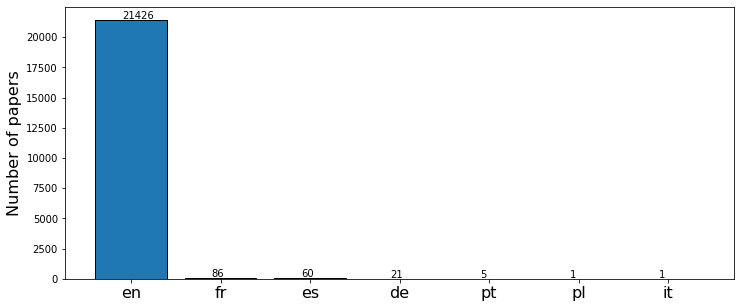

In [16]:
plt.figure(figsize=(12,5))
plt.bar(language_df.index,language_df.language,edgecolor="black")
plt.xticks(fontsize=16)
plt.ylabel("Number of papers",fontsize=16)
for i in range(len(language_df)):
    plt.text(i-0.1,language_df.iloc[i,0]+100,language_df.iloc[i,0])

<a id='Part5_link'></a>
## 5. Exploratory data analysis

In [17]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    parse_dates=["publish_time"],usecols=["title","abstract","body_text","pubmed_id","publish_time","journal","paper_id","title_wordcount_raw","abstract_wordcount_raw","text_wordcount_raw"])


<a id='Part5.1_link'></a>
### 5.1 Check journals

In [19]:
journal_df=data_df.journal.value_counts().to_frame()
print("Total number of journals: {}".format(len(journal_df)))
journal_df.head()

Total number of journals: 2462


,journal
PLoS One,1505
Virology,611
Viruses,541
Arch Virol,487
Sci Rep,435


Text(0.5, 1.0, 'Distribution of number of papers for the top20 journals')

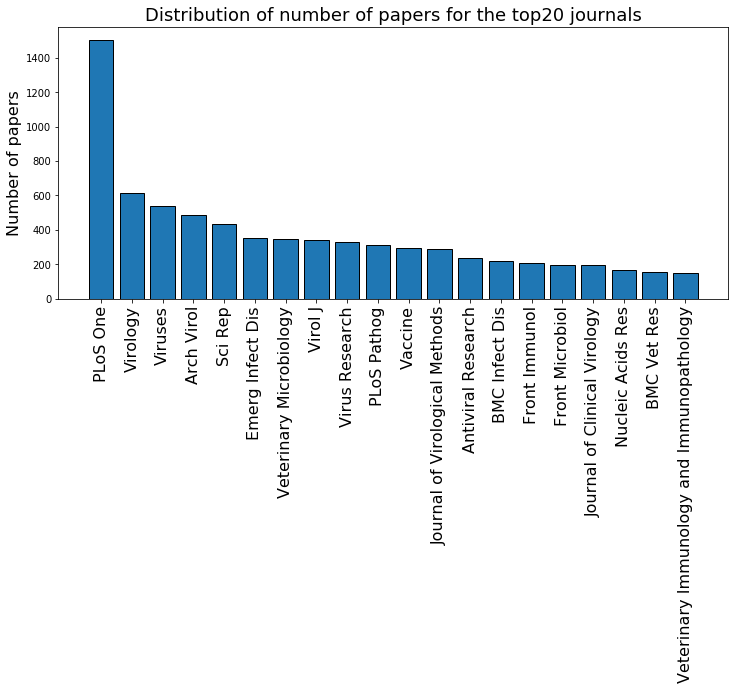

In [24]:
journal_top20_df=journal_df.iloc[:20,:]
plt.figure(figsize=(12,5))
plt.bar(np.arange(20),journal_top20_df.journal,edgecolor="black")
plt.xticks(np.arange(20),journal_top20_df.index,fontsize=16,rotation=90)
plt.ylabel("Number of papers",fontsize=16)
plt.title("Distribution of number of papers for the top20 journals",fontsize=18)

<a id='Part5.2_link'></a>
### 5.2 publish_time

In [25]:
def datetime_info(df,col):
    df["year"]=df[col].apply(lambda x:x.year)
    df["month"]=df[col].apply(lambda x:x.month)
    df["day_of_year"]=df[col].apply(lambda x:x.timetuple().tm_yday)
    return df

In [26]:
data_df=datetime_info(data_df,"publish_time")

In [27]:
publish_year_df=data_df.year.value_counts().to_frame().reset_index().rename(columns={"year":"counts","index":"year"}).sort_values(by=["counts"],ascending=False)


In [28]:
publish_year_df.head()

,year,counts
0,2019,2037
1,2018,1858
2,2017,1713
3,2016,1662
4,2015,1598


Text(0.5, 1.0, 'Distribution of number of papers published in each year')

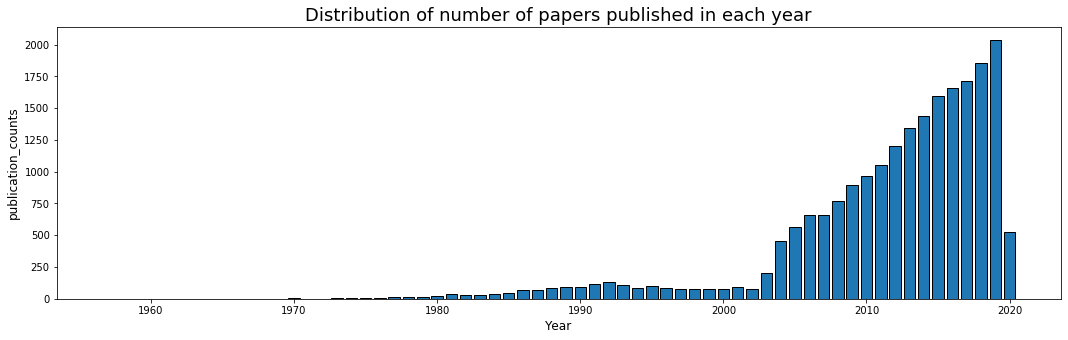

In [30]:
plt.figure(figsize=(18,5))
plt.bar(publish_year_df.year, publish_year_df.counts,edgecolor="black")
plt.xlabel("Year",fontsize=12)
plt.ylabel("publication_counts",fontsize=12)
plt.title("Distribution of number of papers published in each year",fontsize=18)

<a id='Part5.3_link'></a>
### 5.3 wordcount

In [31]:
data_df.loc[:,["title_wordcount_raw","abstract_wordcount_raw","text_wordcount_raw"]].describe()

,title_wordcount_raw,abstract_wordcount_raw,text_wordcount_raw
count,21423.000000,21423.000000,21423.000000
mean,14.221398,217.736451,4372.725249
std,7.521472,139.116833,2818.464387
min,1.000000,1.000000,13.000000
25%,10.000000,148.000000,2744.000000
50%,14.000000,200.000000,3838.000000
75%,17.000000,255.000000,5385.000000
max,274.000000,3694.000000,81687.000000


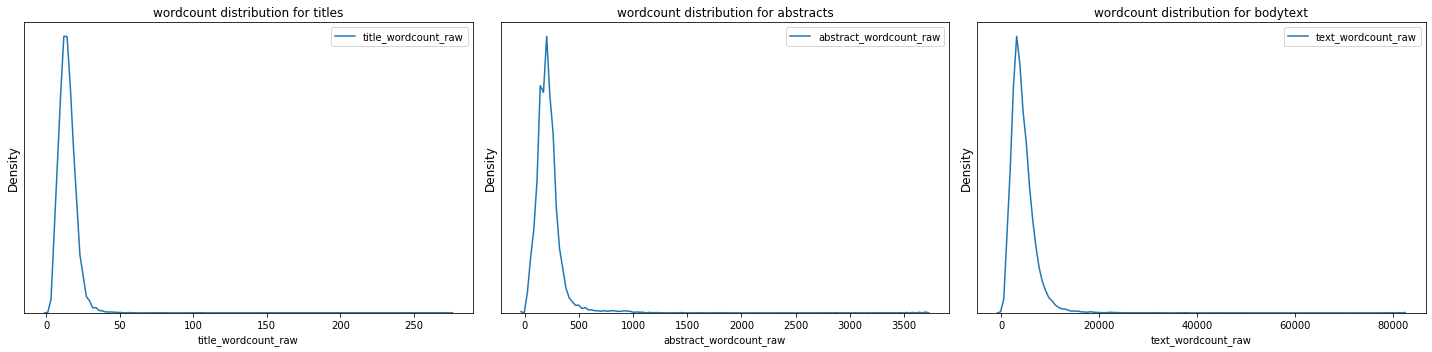

In [37]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sns.distplot(data_df["title_wordcount_raw"],hist=False,ax=axes[0],label="title_wordcount_raw")
axes[0].set_title("wordcount distribution for titles",fontsize=12)
sns.distplot(data_df["abstract_wordcount_raw"],hist=False,ax=axes[1],label="abstract_wordcount_raw")
axes[1].set_title("wordcount distribution for abstracts",fontsize=12)
sns.distplot(data_df["text_wordcount_raw"],hist=False,ax=axes[2],label="text_wordcount_raw")
axes[2].set_title("wordcount distribution for bodytext",fontsize=12)
for i in range(3):
    axes[i].set_yticks([])
    axes[i].set_ylabel("Density",fontsize=12)
plt.tight_layout()